# Predicting funding of DonorsChoose.org teacher proposals

## Models
Using 

## Conclusions

## Next steps
- **Feature Engineering**
        - Add the feature engineering (remapping of rare categories) to the sklearn pipeline to expose parameters to optimization
        - Natural Language Processing of text features (e.g. proposal essays)
        - Use some of the sparse features (e.g. schoolid, teacherid) 
- **More algorithms** Explore non-tree based learning algorithms (esp SVM), and possibly stacking
- **Feature Selection** - Try RFECV rather than SelectFromModel (more accurate but slower)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Machine Learning 
import sklearn
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, TimeSeriesSplit  # StratifiedKFold
from sklearn.model_selection import cross_val_score, learning_curve, GridSearchCV

from xgboost import XGBClassifier

# Interpretation of model results
from pdpbox import pdp, get_dataset, info_plots
import shap

In [2]:
#Session info
import sys
print(sys.version)

[print(f'{lib.__name__} version {lib.__version__}') for lib in [pd, np, sklearn]]

3.6.6 |Anaconda, Inc.| (default, Jun 28 2018, 11:27:44) [MSC v.1900 64 bit (AMD64)]
pandas version 0.23.4
numpy version 1.15.1
sklearn version 0.20.0


[None, None, None]

# Load and inspect data

In [3]:
df_projects = pd.read_csv('./data/projects.csv')
df_outcomes = pd.read_csv('./data/outcomes.csv')
df_essays = pd.read_csv('./data/essays.csv')

In [4]:
def recode_tf_binary(df):
    """Recodes t/f to 0/1 dummies in anticipation of later ML models"""
    d = {'f':0, 't':1}
    for col in df.columns: 
        if all(val in ['f','t', np.nan] for val in df[col].unique().tolist()):
            df[col] = df[col].map(d)
    return df

In [5]:
df_outcomes = recode_tf_binary(df_outcomes)
df_projects = recode_tf_binary(df_projects)

In [6]:
df_projects.columns

Index(['projectid', 'teacher_acctid', 'schoolid', 'school_ncesid',
       'school_latitude', 'school_longitude', 'school_city', 'school_state',
       'school_zip', 'school_metro', 'school_district', 'school_county',
       'school_charter', 'school_magnet', 'school_year_round', 'school_nlns',
       'school_kipp', 'school_charter_ready_promise', 'teacher_prefix',
       'teacher_teach_for_america', 'teacher_ny_teaching_fellow',
       'primary_focus_subject', 'primary_focus_area',
       'secondary_focus_subject', 'secondary_focus_area', 'resource_type',
       'poverty_level', 'grade_level', 'fulfillment_labor_materials',
       'total_price_excluding_optional_support',
       'total_price_including_optional_support', 'students_reached',
       'eligible_double_your_impact_match', 'eligible_almost_home_match',
       'date_posted'],
      dtype='object')

In [7]:
df_outcomes.describe(include='all')

,projectid,is_exciting,at_least_1_teacher_referred_donor,fully_funded,at_least_1_green_donation,great_chat,three_or_more_non_teacher_referred_donors,one_non_teacher_referred_donor_giving_100_plus,donation_from_thoughtful_donor,great_messages_proportion,teacher_referred_count,non_teacher_referred_count
count,619326,619326.000000,524928.000000,619326.000000,524928.000000,619326.000000,524928.000000,524928.000000,524928.000000,439487.00000,524928.000000,524928.000000
unique,619326,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,d4462c154c80de854178accb46d84306,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.059274,0.237480,0.695406,0.721419,0.302216,0.518886,0.719735,0.013213,52.92709,0.777339,4.361290
std,NaN,0.236137,0.425539,0.460236,0.448301,0.459219,0.499644,0.449129,0.114187,35.71410,2.227933,5.668748
min,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.00000,0.000000,1.000000
50%,NaN,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,50.00000,0.000000,3.000000
75%,NaN,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,83.00000,0.000000,5.000000


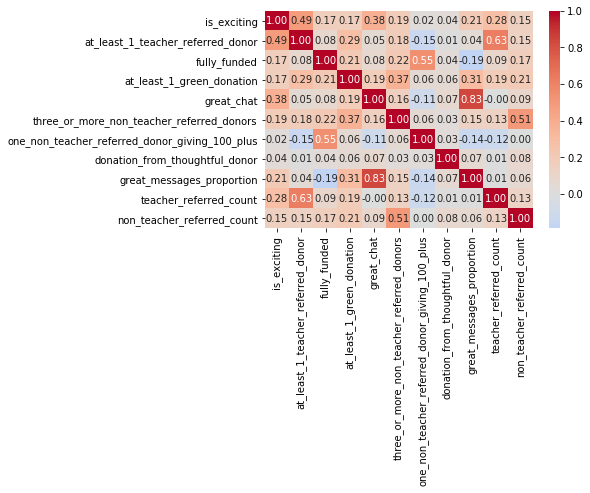

In [8]:
corr = df_outcomes.drop(columns='projectid').corr()
g = sns.heatmap(corr, annot=True, fmt = ".2f", cmap = "coolwarm", center=0)

In [9]:
corr.fully_funded.sort_values(ascending=False)

fully_funded                                      1.000000
one_non_teacher_referred_donor_giving_100_plus    0.547017
three_or_more_non_teacher_referred_donors         0.218347
at_least_1_green_donation                         0.214017
is_exciting                                       0.166128
non_teacher_referred_count                        0.165221
teacher_referred_count                            0.093554
at_least_1_teacher_referred_donor                 0.079961
great_chat                                        0.079323
donation_from_thoughtful_donor                    0.036309
great_messages_proportion                        -0.188422
Name: fully_funded, dtype: float64

In [10]:
df_projects.shape

(664098, 35)

In [11]:
df_outcomes.shape

(619326, 12)

In [12]:
outcome = 'fully_funded'

In [13]:
df_essays.drop('teacher_acctid', axis = 1, inplace=True)  # also in df_projets
data = pd.merge(df_essays, df_projects, on = 'projectid')
df = pd.merge(data, df_outcomes[['projectid', outcome]])  # just use outcome, as other outcome features would cause leakage 
df.shape

(619326, 40)

# Exploratory  Data Analysis (very expedited)

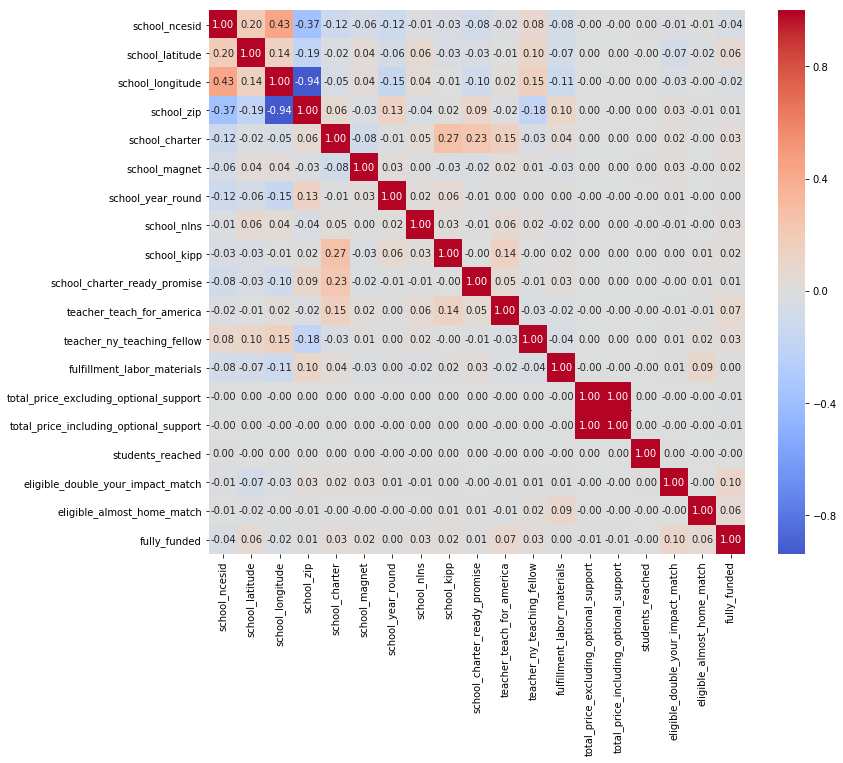

In [14]:
cols = df.select_dtypes(exclude='O').columns
corr = df[cols].corr()
plt.figure(figsize=[12,10])
g = sns.heatmap(corr,annot=True, fmt = ".2f", cmap = "coolwarm", center=0)

In [15]:
corr['fully_funded'].sort_values(ascending=False)

fully_funded                              1.000000
eligible_double_your_impact_match         0.097188
teacher_teach_for_america                 0.069738
school_latitude                           0.061257
eligible_almost_home_match                0.055720
teacher_ny_teaching_fellow                0.032863
school_charter                            0.032069
school_nlns                               0.025048
school_magnet                             0.018631
school_kipp                               0.018457
school_charter_ready_promise              0.013466
school_zip                                0.006217
fulfillment_labor_materials               0.004677
school_year_round                         0.001255
students_reached                         -0.002840
total_price_including_optional_support   -0.009418
total_price_excluding_optional_support   -0.009551
school_longitude                         -0.023831
school_ncesid                            -0.038652
Name: fully_funded, dtype: floa

In [16]:
#Price per student
df['price_per_student'] = df.total_price_including_optional_support / df.students_reached
# NOTE - different ways to impute price per student when students_reached is 0
# could either divide by median students, or leave missing. I'll try the former for now
median_students = df[df.students_reached > 0].students_reached.median()
df.loc[df.students_reached == 0, 'price_per_student'] = df.total_price_including_optional_support / median_students

expensive_projects = (df.students_reached > 0) & (df.price_per_student > 1000)
print(df[expensive_projects][outcome].count())
print(df[expensive_projects][outcome].mean())

271
0.4022140221402214


In [17]:
df[expensive_projects][['fully_funded', 'title', 'short_description', 
                        'students_reached', 'total_price_including_optional_support']].head()

,fully_funded,title,short_description,students_reached,total_price_including_optional_support
1412,1,Trip to France,We would appreciate your support for this stud...,1.0,2440.00
1825,1,Laptop to Enable Student to Produce Written Work,I am submitting a proposal for a laptop with s...,1.0,1181.71
3654,1,France and Spain Educational Tour,I want to change the way our world language st...,6.0,12054.09
5341,0,Help An Immigrant Student Work His Way Towards...,I truly believe that having a laptop to use in...,1.0,2284.15
5708,1,Help Me Go to Harvard Part 3,I began teaching the most amazing students thr...,1.0,1021.95


In [18]:
#VERY expensive
df[(df.students_reached > 0) & (df.price_per_student > 10000)][['fully_funded', 'title', 'short_description']].head()

,fully_funded,title,short_description
139070,0,fkjghoignjg,fnli uglzbgf uigl fn liuglz bgfu igl fnli uglz...
273672,0,TEST - PLEASE DO NOT DONATE,NaN
313431,1,Urgent Reading Intervention Needed!,"Just imagine what it feels like to be sixteen,..."
613975,1,Give Cindy a Voice,"Cindy is very bright. She is patient, kind an..."


In [19]:
def plot_continuous_var(var, df= df, nobs = 20_000, max_val = np.inf):
    """Plots continuous variable, subsetting nobs for speed"""
    ax = sns.regplot(x=var, y=outcome, data=df.iloc[:nobs].query(f'{var} < {max_val}'), lowess=True, y_jitter=.03) 

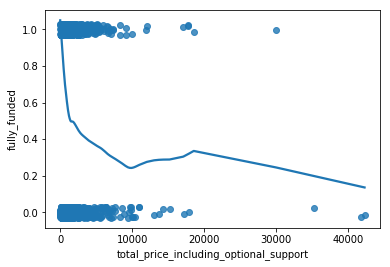

In [20]:
plot_continuous_var('total_price_including_optional_support')

In [21]:
def plot_categorical_var(varname, df=df, n=100_000, height=4):
    """Plots categorical variable, subsetting nobs for speed"""
    g = sns.catplot(varname,data=df[:n],kind="count", height=height)
    g.set_xticklabels(rotation=90)
    g = sns.catplot(x=varname,y=outcome,data=df[:n],kind="bar", height=height)
    g.set_xticklabels(rotation=90)

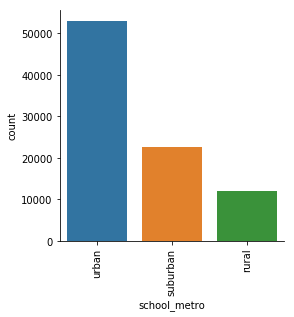

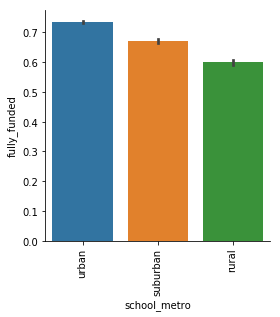

In [22]:
plot_categorical_var('school_metro')

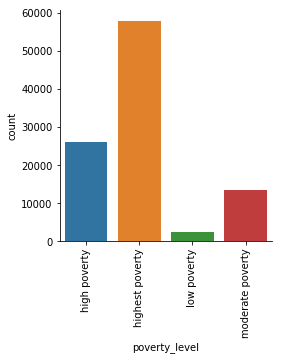

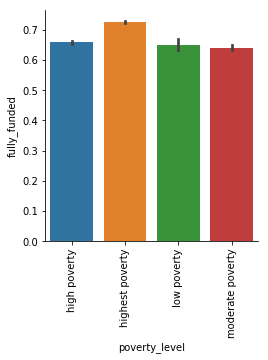

In [23]:
plot_categorical_var('poverty_level')

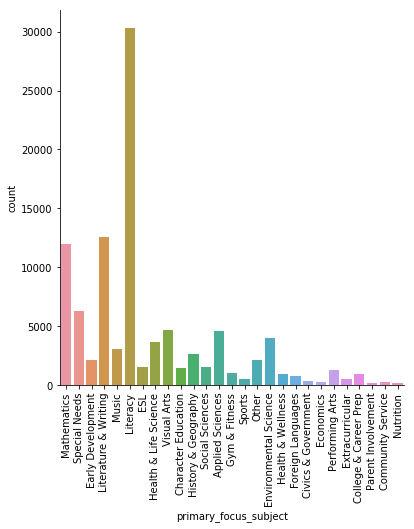

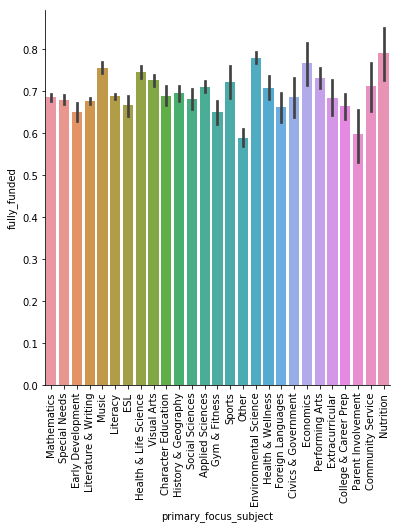

In [24]:
plot_categorical_var('primary_focus_subject', height=6)

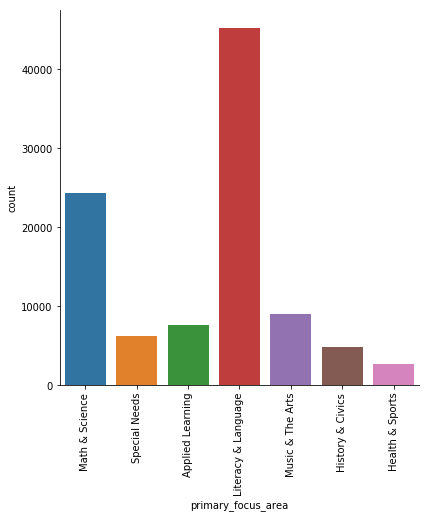

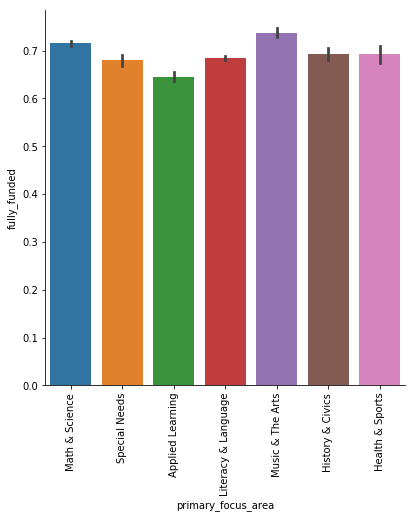

In [25]:
plot_categorical_var('primary_focus_area', height=6)

# Temporal Trends
Interestingly, there seem to be seasonal fluctuations in funding patterns. Given the school year, it makes sense that many projects are posted in the fall, though it is unclear why those in the fall tend to have 10% higher success rate than those in the spring. 
The number of projects posted has drastically increased each year. Success rate dropped during the first few years, but since has remained somewhat constant since 2005.

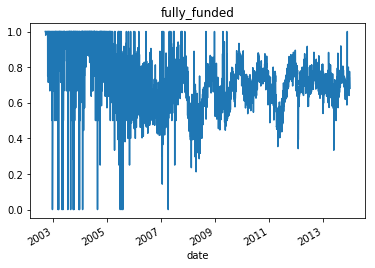

In [26]:
df['date'] = pd.to_datetime(df.date_posted)
def plot_var_over_time(varname, df = df):
    ts = df.groupby(['date'])[varname].mean() #.reset_index()
    ts.plot(title=varname)
plot_var_over_time(outcome)

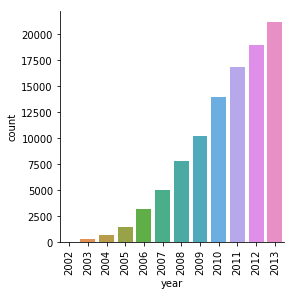

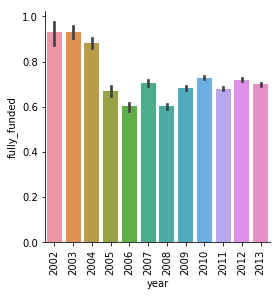

In [27]:
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
plot_categorical_var('year')

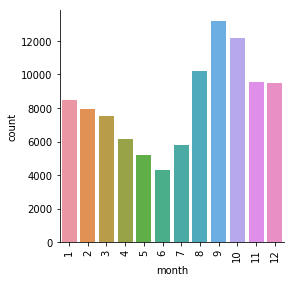

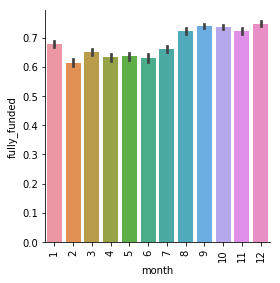

In [28]:
plot_categorical_var('month')

## For high-dimensionality features, encode them with a minimum relative or absolute threshold
**Note** - future work would put this into the model pipeline itself, so that the parameters can be tuned
<br> For now, map and cities, states, and subjects with <1% occurrence to "OTHER"

In [29]:
def map_categoricals(feature:pd.Series, threshold=0.01, noisy=True):
    """Maps rare feature occurences to 'OTHER' if occurence is less than absolute or relative threshold """
    if threshold < 1:
        threshold *= len(feature) 
    tabs = feature.value_counts()
    levels = tabs[tabs > threshold]
    if noisy:
        print(f'Reducing levels from {len(tabs)} to {len(levels)}')
    feature_encoded = feature.apply(lambda x: x if x in levels else 'OTHER')
    return feature_encoded

In [30]:
df['state_mapped'] = map_categoricals(df.school_state)
df['city_mapped'] = map_categoricals(df.school_city)
df['primary_focus_subject_mapped'] = map_categoricals(df.primary_focus_subject)

Reducing levels from 52 to 30
Reducing levels from 8833 to 11
Reducing levels from 27 to 17


# Split data into training and testing
To simulate a real world problem, I'll use the last year of data (2013) as the test data, and only use old data to train the model (validating using a time-series approach). This may decrease accuracy but will increase generalizability

In [31]:
cols_to_keep = [
    'school_metro', 'school_charter', 'school_magnet', 
    'school_year_round', 'school_nlns', 'school_kipp',
    'school_charter_ready_promise', 'teacher_prefix',
    'teacher_teach_for_america', 'teacher_ny_teaching_fellow',
    'primary_focus_area', 'resource_type',
   'poverty_level', 'grade_level', 'fulfillment_labor_materials',
   'total_price_excluding_optional_support', 'students_reached',
   'eligible_double_your_impact_match', 'eligible_almost_home_match',
   'price_per_student', 'month', 'year',
    'state_mapped', 'city_mapped', 'primary_focus_subject_mapped'
]

cols_to_drop = [
    'projectid',  # unique identifier
    'title', 'short_description', 'need_statement', 'essay',  # could do NLP later
    'teacher_acctid', 'schoolid', 'school_ncesid', 'school_district', 'school_county', 'school_zip' # could try using these identifiers later
    'date', 'date_posted',  # has already had month and year extracted
    'secondary_focus_subject', 'secondary_focus_area'  # high dimensionality, try later
    'school_state', 'school_city', 'primary_focus_subject' # were mapped to lower dimensionality features
    'total_price_including_optional_support', # correlated with other price feature, could do PCA or feature selection 
    'school_latitude', 'school_longitude',  # need a better way to handle location
]

# Make sure I didn't forget any columns
assert all([col in cols_to_keep + cols_to_drop] for col in df.columns)

In [32]:
df_test = df.query('year == 2013')
df_train = df.query('year < 2013')
X = df_train[cols_to_keep]
y = df_train[outcome]
X_test = df_test[cols_to_keep]
y_test = df_test[outcome]

# TEMP - subset for faster model development
# X = X[:100_000]
# y = y[:100_000]

In [33]:
# Use a time series split
# kfold = StratifiedKFold(n_splits=5, random_state=0)
tscv = TimeSeriesSplit(n_splits=5)

In [34]:
def pipeline_cv_score(model_pipeline, X, y, n_jobs=-1):
    """Display cross-validation score of a pipeline given data X and y"""
    cv_score = cross_val_score(model_pipeline, X, y, cv=tscv, n_jobs=n_jobs)
    print(f'Cross Validation Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')
    
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, scoring=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

def plot_feature_importances(df, n=20, threshold=None, return_df=False):
    """
    Slightly adapted from https://www.kaggle.com/willkoehrsen/a-complete-introduction-and-walkthrough
    Plots n most important features. Also plots the cumulative importance if
    threshold is specified and prints the number of features needed to reach threshold cumulative importance.
    Intended for use with any tree-based feature importances.
    Args:
        df (dataframe): Dataframe of feature importances. Columns must be "feature" and "importance".
        n (int): Number of most important features to plot. Default is 15.
        threshold (float): Threshold for cumulative importance plot. If not provided, no plot is made. Default is None.
    Returns:
        df (dataframe): Dataframe ordered by feature importances with a normalized column (sums to 1)
                        and a cumulative importance column
    Note:
        * Normalization in this case means sums to 1.
        * Cumulative importance is calculated by summing features from most to least important
        * A threshold of 0.9 will show the most important features needed to reach 90% of cumulative importance
    """
    plt.style.use('fivethirtyeight')

    # Sort features with most important at the head
    df = df.sort_values('importance', ascending=False).reset_index(drop=True)

    # Normalize the feature importances to add up to one and calculate cumulative importance
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    plt.rcParams['font.size'] = 12

    # Bar plot of n most important features
    plt.figure(figsize=(8, 0.5*n))
    df.loc[:n, :].plot.barh(y='importance_normalized',
                            x='feature', color='darkgreen',
                            edgecolor='k', figsize=(12, 8),
                            legend=False, linewidth=2)

    plt.xlabel('Normalized Importance', size=18);
    plt.ylabel('');
    plt.title(f'{n} Most Important Features', size=18)
    plt.gca().invert_yaxis()

    if threshold:
        # Cumulative importance plot
        plt.figure(figsize=(8, 6))
        plt.plot(list(range(len(df))), df['cumulative_importance'], 'b-')
        plt.xlabel('Number of Features', size=16);
        plt.ylabel('Cumulative Importance', size=16);
        plt.title('Cumulative Feature Importance', size=18);

        # Number of features needed for threshold cumulative importance
        # This is the index (will need to add 1 for the actual number)
        importance_index = np.min(np.where(df['cumulative_importance'] > threshold))

        # Add vertical line to plot
        plt.vlines(importance_index + 1, ymin=0, ymax=1.05, linestyles='--', colors='red')
        plt.show();

        print('{} features required for {:.0f}% of cumulative importance.'.format(importance_index + 1,
                                                                                  100 * threshold))

    if return_df:
        return df

# Build a RandomForest model, and inspect its performance
**Note** - For now I won't fully tune this model 

In [35]:
num_cols = X.select_dtypes(['integer', 'float']).columns.tolist()
num_si_step = ('si', SimpleImputer(strategy='median'))
num_ss_step = ('ss', StandardScaler())
num_steps = [num_si_step] #num_ss_step - for now we won't use scaling, as it shouldn't matter for tree-based algorithms 
num_pipe = Pipeline(num_steps)
num_transformers = [('num', num_pipe, num_cols)]

cat_cols = X.select_dtypes('O').columns.tolist()
cat_si_step = ('si', SimpleImputer(strategy='constant',
                   fill_value='MISSING'))
# cat_si_step = ('si', SimpleImputer(strategy='most_frequent'))  # seems way slower
cat_ohe_step = ('ohe', OneHotEncoder(sparse=False,
                    handle_unknown='ignore'))
cat_steps = [cat_si_step, cat_ohe_step]
cat_pipe = Pipeline(cat_steps)
cat_transformers = [('cat', cat_pipe, cat_cols)]

transformers = [('cat', cat_pipe, cat_cols),
                    ('num', num_pipe, num_cols)]
ct = ColumnTransformer(transformers=transformers)

# Parameters chosen from previous quick-and-dirty tuning
classifier = RandomForestClassifier(max_depth=15, n_estimators=20, random_state=42) 
pipeline = Pipeline([('transformer', ct),
                     ('classifier', classifier)])


In [36]:
%%time
pipeline_cv_score(pipeline, X, y)

Cross Validation Score = 0.7309 with std = 0.0025
Wall time: 48.5 s


Wall time: 46.4 s


<module 'matplotlib.pyplot' from 'c:\\users\\zrankin\\appdata\\local\\continuum\\miniconda3\\envs\\kaggle\\lib\\site-packages\\matplotlib\\pyplot.py'>

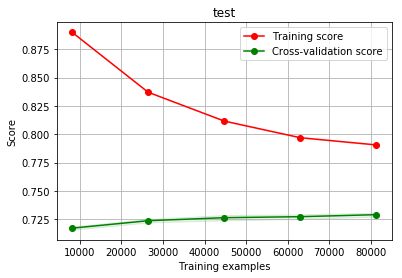

In [37]:
%%time
plot_learning_curve(pipeline, 'test', X, y, cv=tscv)

## For many model inspection tools, we want the feature names, which are mangled during OneHotEncoding. Here, we create a pd.DataFrame using the transformer pipeline and adding feature names 

In [38]:
def rename_features(feature_list, old, new):
    return [f.replace(old, new) for f in feature_list]
    
def rename_ohe_features(ohe_feature_list, column_names):
    """
    Utility function to add original feature names after sklearn OneHotEncoder
    e.g. if 'myfeature' is encoded, it gives ['x0_cat1', 'x0_cat2']
    rename_ohe_features(['x0_cat1', 'x0_cat2'], 'myfeature') 
    returns ['myfeature_cat1', 'myfeature_cat2']
    """
    for i, col in enumerate(column_names):
        ohe_feature_list = rename_features(ohe_feature_list, f'x{i}', col)
    return ohe_feature_list

In [39]:
X_transformed = ct.fit_transform(X)

In [40]:
# Get the feature names from pipeline
ohe_feature_list = list(ct.named_transformers_['cat'].named_steps['ohe'].get_feature_names())
cat_features = rename_ohe_features(ohe_feature_list, cat_cols)
cat_features

['school_metro_MISSING',
 'school_metro_rural',
 'school_metro_suburban',
 'school_metro_urban',
 'teacher_prefix_Dr.',
 'teacher_prefix_Mr.',
 'teacher_prefix_Mr. & Mrs.',
 'teacher_prefix_Mrs.',
 'teacher_prefix_Ms.',
 'primary_focus_area_Applied Learning',
 'primary_focus_area_Health & Sports',
 'primary_focus_area_History & Civics',
 'primary_focus_area_Literacy & Language',
 'primary_focus_area_MISSING',
 'primary_focus_area_Math & Science',
 'primary_focus_area_Music & The Arts',
 'primary_focus_area_Special Needs',
 'resource_type_Books',
 'resource_type_MISSING',
 'resource_type_Other',
 'resource_type_Supplies',
 'resource_type_Technology',
 'resource_type_Trips',
 'resource_type_Visitors',
 'poverty_level_high poverty',
 'poverty_level_highest poverty',
 'poverty_level_low poverty',
 'poverty_level_moderate poverty',
 'grade_level_Grades 3-5',
 'grade_level_Grades 6-8',
 'grade_level_Grades 9-12',
 'grade_level_Grades PreK-2',
 'grade_level_MISSING',
 'state_mapped_AZ',
 'state_mapped_CA',
 'state_mapped_CO',
 'state_mapped_CT',
 'state_mapped_DC',
 'state_mapped_FL',
 'state_mapped_GA',
 'state_mapped_IL',
 'state_mapped_IN',
 'state_mapped_LA',
 'state_mapped_MA',
 'state_mapped_MD',
 'state_mapped_MI',
 'state_mapped_MO',
 'state_mapped_MS',
 'state_mapped_NC',
 'state_mapped_NJ',
 'state_mapped_NV',
 'state_mapped_NY',
 'state_mapped_OH',
 'state_mapped_OK',
 'state_mapped_OR',
 'state_mapped_OTHER',
 'state_mapped_PA',
 'state_mapped_SC',
 'state_mapped_TN',
 'state_mapped_TX',
 'state_mapped_UT',
 'state_mapped_VA',
 'state_mapped_WA',
 'state_mapped_WI',
 'city_mapped_Bronx',
 'city_mapped_Brooklyn',
 'city_mapped_Charlotte',
 'city_mapped_Chicago',
 'city_mapped_Houston',
 'city_mapped_Indianapolis',
 'city_mapped_Los Angeles',
 'city_mapped_New York',
 'city_mapped_OTHER',
 'city_mapped_Philadelphia',
 'city_mapped_San Francisco',
 'city_mapped_Washington',
 'primary_focus_subject_mapped_Applied Sciences',
 'primary_focus_subject_mapped_Character Education',
 'primary_focus_subject_mapped_ESL',
 'primary_focus_subject_mapped_Early Development',
 'primary_focus_subject_mapped_Environmental Science',
 'primary_focus_subject_mapped_Gym & Fitness',
 'primary_focus_subject_mapped_Health & Life Science',
 'primary_focus_subject_mapped_History & Geography',
 'primary_focus_subject_mapped_Literacy',
 'primary_focus_subject_mapped_Literature & Writing',
 'primary_focus_subject_mapped_Mathematics',
 'primary_focus_subject_mapped_Music',
 'primary_focus_subject_mapped_OTHER',
 'primary_focus_subject_mapped_Other',
 'primary_focus_subject_mapped_Performing Arts',
 'primary_focus_subject_mapped_Social Sciences',
 'primary_focus_subject_mapped_Special Needs',
 'primary_focus_subject_mapped_Visual Arts']

In [41]:
# Get a pd.DataFrame with the feature names 
df_transformed = pd.DataFrame(X_transformed, columns=cat_features + num_cols)
df_transformed.shape

(487997, 110)

In [42]:
df_transformed.head()

,school_metro_MISSING,school_metro_rural,school_metro_suburban,school_metro_urban,teacher_prefix_Dr.,teacher_prefix_Mr.,teacher_prefix_Mr. & Mrs.,teacher_prefix_Mrs.,teacher_prefix_Ms.,primary_focus_area_Applied Learning,...,teacher_teach_for_america,teacher_ny_teaching_fellow,fulfillment_labor_materials,total_price_excluding_optional_support,students_reached,eligible_double_your_impact_match,eligible_almost_home_match,price_per_student,month,year
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,9.0,703.34,90.0,0.0,0.0,9.530333,10.0,2009.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,35.0,207.43,8.0,0.0,0.0,30.505000,6.0,2011.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,35.0,440.01,25.0,1.0,0.0,20.706400,9.0,2010.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,17.0,798.85,20.0,0.0,0.0,48.710500,4.0,2009.0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,30.0,797.30,11.0,0.0,0.0,85.272727,12.0,2012.0


In [43]:
classifier.fit(df_transformed, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

<Figure size 576x1080 with 0 Axes>

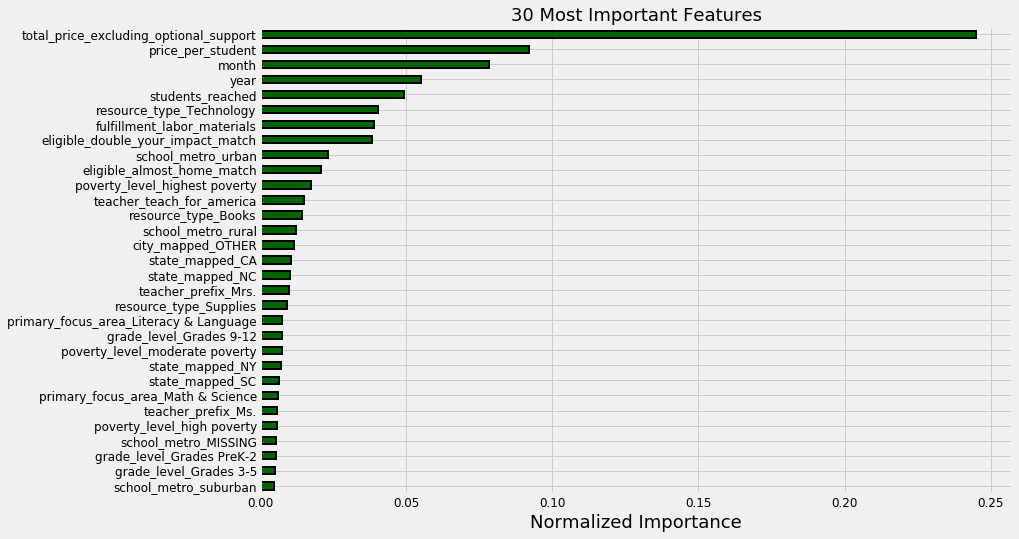

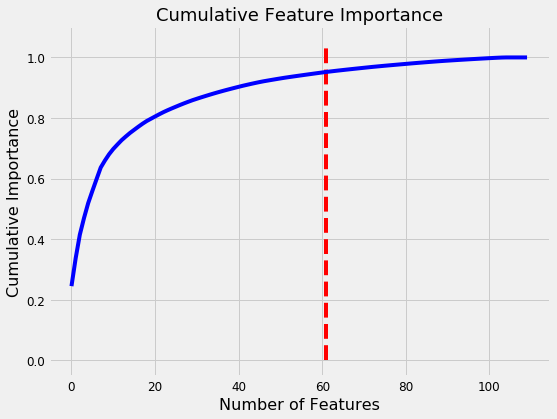

61 features required for 95% of cumulative importance.


In [44]:
# Feature importances
features = df_transformed.columns
feature_importances = pd.DataFrame({'feature': features, 'importance': classifier.feature_importances_})
feature_importances = feature_importances.sort_values('importance', ascending=False)

plot_feature_importances(feature_importances, n=30, threshold=0.95)

In [45]:
row_to_show = 1
data_for_prediction = df_transformed.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)
# Create object that can calculate shap values
explainer = shap.TreeExplainer(classifier)
# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

classifier.predict(data_for_prediction_array)

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

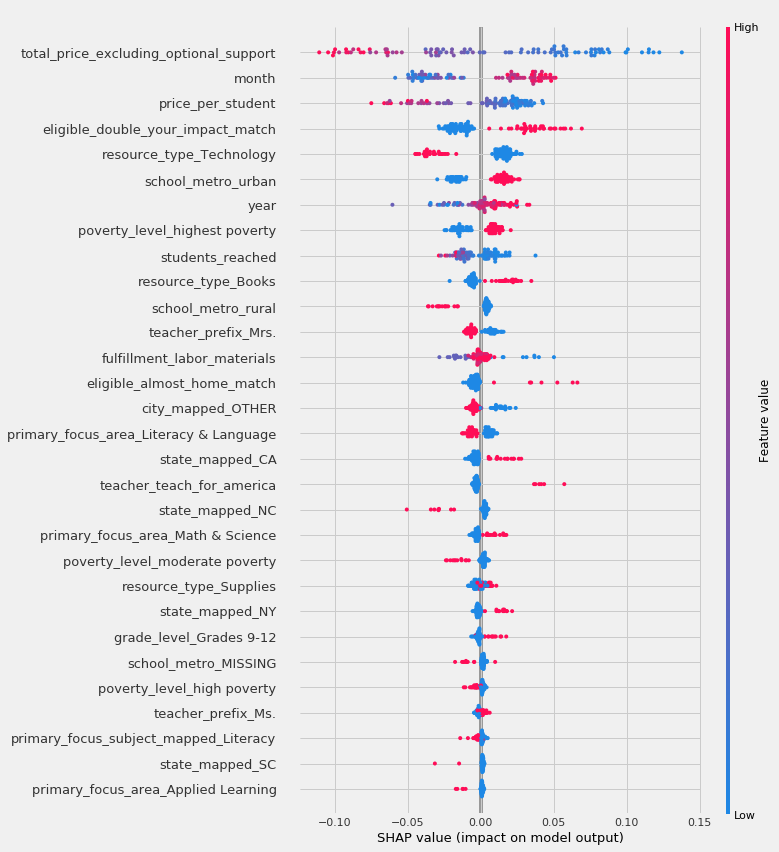

In [46]:
df_subset = df_transformed.sample(100, random_state=42)
shap_values = explainer.shap_values(df_subset)
shap.summary_plot(shap_values[1], df_subset, max_display=30)

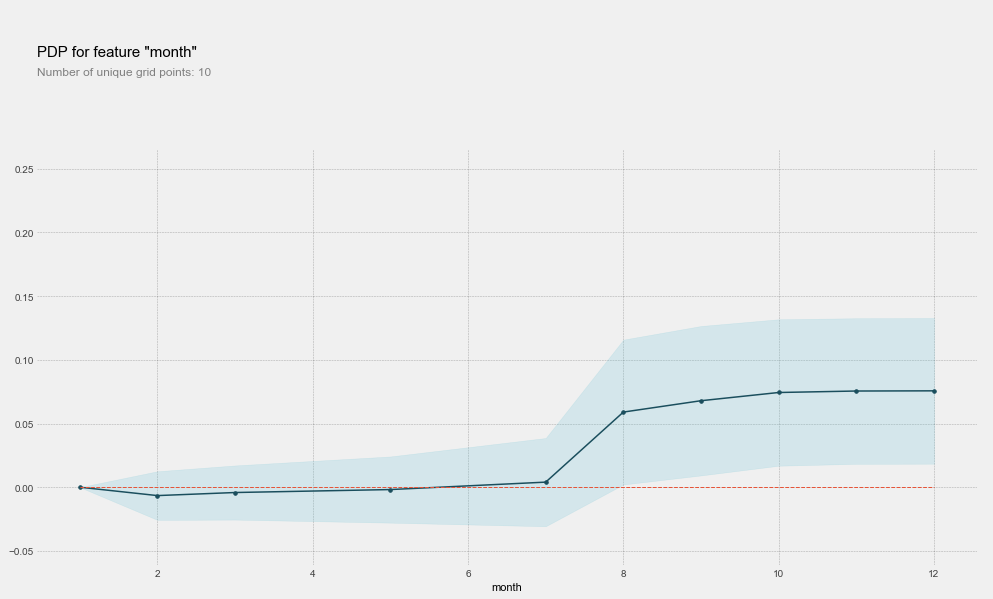

In [47]:
pdp_feature = pdp.pdp_isolate(model=classifier, dataset=df_transformed, model_features=df_transformed.columns.tolist(), feature='month')
pdp.pdp_plot(pdp_feature, 'month')
plt.show()

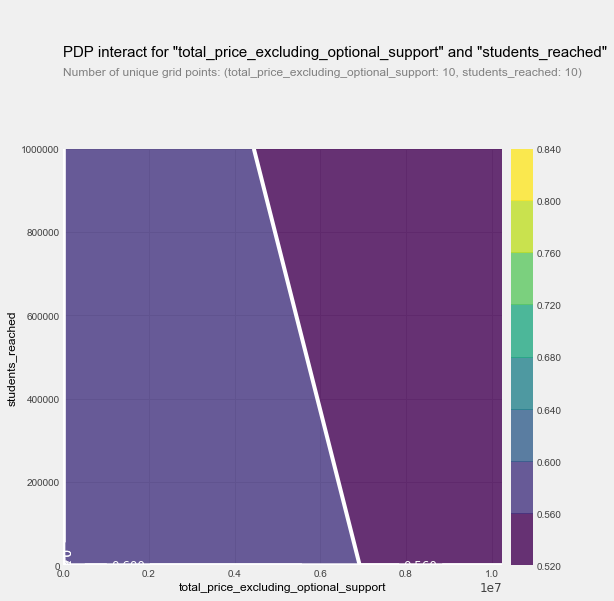

In [48]:
features_to_plot = ['total_price_excluding_optional_support', 'students_reached']
inter1  =  pdp.pdp_interact(model=classifier, dataset=df_transformed, model_features=df_transformed.columns.tolist(), features=features_to_plot)
pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour')
plt.show()

## XGBoost with early stopping
Let's use a more complex algorithm, then compare results to the RandomForest. We'll later tune the hyperparameters. We will add a feature selection algorithm in the pipeline. 

In [49]:
# First, set aside the 2012 data as the eval_set for early_stopping
idx_2012 = X.loc[X.year == 2012].index
X_train = X.drop(index=idx_2012)
X_val = X.loc[idx_2012]
y_train = y.drop(index=idx_2012)
y_val = y.loc[idx_2012]

# If you wanted to use a naive split
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

eval_set = [(X_val, y_val)]

In [ ]:
classifier = XGBClassifier(max_depth=3, eval_set=eval_set, early_stopping_rounds=10, n_estimators=500, random_state=42)

selection_classifier = ExtraTreesClassifier(max_depth=16, n_estimators=50, random_state=42)  # Note - hasn't been tuned
pipeline = Pipeline([('transformer', ct),
                     ('selection', SelectFromModel(selection_classifier, threshold=None)),
                     ('classifier', classifier)])

In [ ]:
%%time
pipeline_cv_score(pipeline, X_train, y_train)

## GridSearch hyperparameter optimization for XGBoost, then select best model and score on test set (2013 data)
**Note** As this is time-consuming (and I'm just running locally), I'll only vary a few parameters.
<br> Previous optimization showed that using subsampling within xgboost didn't help since overfitting is already controlled with early stopping. It also took significantly longer to fit

In [ ]:
%%time
param_grid = {'selection__threshold': [None, '0.5*mean', 'mean'],
              'classifier__max_depth': [3, 6, 9]}

# It seems that I don't need to use fit_params, as the xgboost eval_set parameter is sufficient
gridsearch = GridSearchCV(pipeline, param_grid=param_grid, cv = tscv, n_jobs=-1)
gridsearch.fit(X_train, y_train)

In [ ]:
grid_cols = ['mean_test_score', 'std_test_score', 'mean_fit_time'] + [key for key in gridsearch.cv_results_.keys() if 'param' in key]
pd.DataFrame(gridsearch.cv_results_).sort_values('mean_test_score', ascending=False)[grid_cols]

In [ ]:
final_model = gridsearch.best_estimator_

In [ ]:
%%time
pipeline_cv_score(final_model, X_train, y_train)

In [ ]:
%%time
plot_learning_curve(final_model, 'Final Model Learning Curve', X_train, y_train, cv=tscv)

In [ ]:
# Use all training data (including the 2012 validation set) to predict 2013
final_model.fit(X, y)
(final_model.predict(X_test) == y_test).mean()